# Introduction

*Schistosoma mansoni* are parasitic worms that cause chronic schistosomiasis. Once inside the host, they trigger an immune response that leads to large tissue granulomas, causing fibrosis, organomegaly, and tissue damage.

*S. mansoni* have a complex life cycle. Eggs from humans exit into the water where they hatch into miracidia which then infect a snail. While in the snail, sporocysts develop and eventually turn into cercariae and are released back into the water. The cercariae then penatrate the skin of human or mouse and become adults and make new eggs, starting the process over. Some portion of the eggs don't go through the intestine and exit the human, but instead can end up in other areas, particularly the liver. The eggs that make it to the intestines continue their life cycle, while the others are trapped and eventually die.

Since most of our previous knowledge is based on studies looking at *S. mansoni* from eggs trapped in the liver instead of the eggs that move through the intestines, we want to understand the differences, if there are any, between miracidia from the liver versus the intestines. A past study was done that determined that was a significant difference in gene expression between eggs isolated from the liver versus the intestines. Our goal is to see if the miracidia also exhibit a significant difference in gene expression between those stuck in the liver and those that make it to the intestines.

# Methods

## RNA extraction, library preparation, and sequencing

Will be written by Dr. Wheeler.

## Read QC and alignment

First, we ran quality control on our raw reads using FastQC (v0.12.1). The reads were then trimmed using Cutadapt (v4.9) with arguments to remove the first 10 base pairs that are the barcode, to remove both the forwared and reverse adapters, and to deal with the incorrect "G" calls due to NextSeq Illumina sequencing. We then reran FastQC to double check the quality after trimming. Reads were then mapped to the *S. mansoni* genome (version WBPS19 from WormBase ParaSite) using STAR (v2.7.10b). Two alignments were done. Qualimap (v2.3) was use to check the quality control of the alignment sequencing data from STAR. Duplicate reads were tagged using MarkDuplicates (v3.2.0). Reads were then assigned to features such as genes, exons, promotors, etc. and counts the numbers of reads assigned to each feature using FeatureCounts (v2.0.6). Lastly, a HTML report of the quality controls was produced using MultiQC (v1.17).

## Identification of differentially expressed genes and GO analysis

Count matrix of reads were filtered to remove reads with a count of 0 and reformatted using R. The reformatted matrix was then used as input for DESeq2 (v1.46.0). The results of DESeq2 were then used to identify significantlly differentially expressed genes (abs(log2FoldChange) > 2 and padj <= 0.05). These genes were then used as input for gProfiler2 (v0.2.3) for functional enrichment analysis.

# Results

## RNA sequencing, alignment, and sample clustering

In [13]:
# Libraries Used
library(tidyverse)
library(gprofiler2)
library(ggplot2)
library(broom)
library(DESeq2)
library(gridExtra)

In [14]:
# Read in counts data
counts_df <- read_tsv('/data/classes/2025/spring/biol443/course_files/rnaseq_data/counts.tsv', comment = '#', show_col_types = FALSE) |>
             mutate(across(where(is.numeric), as.integer))

# Filter data to be used in DESeq2
counts_summary <- counts_df |>
    select(Geneid, contains('.bam')) |>
    rename_with(~str_remove(., "dedup/star/.*:"), everything()) |>
    rowwise() |>
    mutate(total_counts = sum(c_across(where(is.numeric)), na.rm = T)) |>
    filter(total_counts >= 10)

sample_summary <- counts_df |>
    select(Geneid, contains('.bam')) |>
    rename_with(~str_remove(., "dedup/star/.*:"), everything()) |>
    pivot_longer(-Geneid, names_to = 'sample', values_to = 'count') |>
    filter(count > 0) |>
    group_by(Geneid) |>
    tally() |>
    filter(n <= 3)

genes_to_remove = sample_summary$Geneid

counts_filt <- counts_summary |>
    filter(!Geneid %in% genes_to_remove) |>
    arrange(Geneid) |>
    select(-total_counts)

counts_m <- counts_filt |>
    select(-Geneid) |>
    as.matrix()
rownames(counts_m) <- counts_filt$Geneid

metadata <- data.frame(sample_id = colnames(counts_m)) |>
    mutate(tissue = str_sub(sample_id, 1, 3),
           rep = str_sub(sample_id, 5))
rownames(metadata) <- metadata$sample_id
metadata <- select(metadata, -sample_id)

# Run DESeq2
dds <- suppressWarnings({
    DESeqDataSetFromMatrix(countData = counts_m,
                              colData = metadata,
                              design = ~ tissue)})
dds <- DESeq(dds, quiet = TRUE)

res <- results(dds)

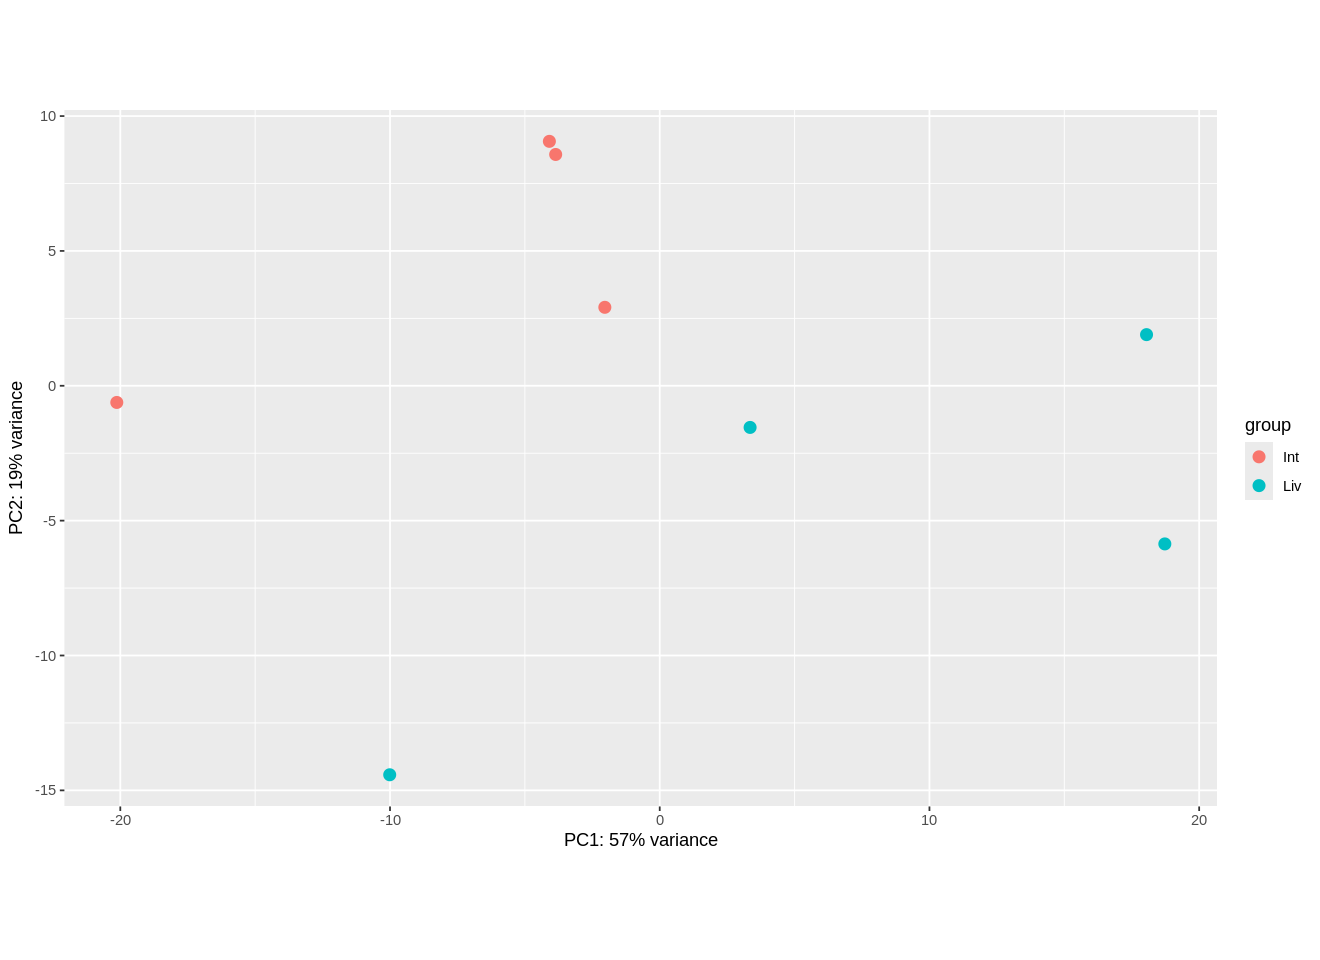

In [32]:
# Create and output PCA plot
options(repr.plot.width = 11, repr.plot.height = 8)
vsd <- varianceStabilizingTransformation(dds)
pca <- plotPCA(vsd, intgroup = 'tissue')
pca

The PCA plot shows that the miracida from the liver and the intestines are in two distinct clusters. This tells us that there is a clear difference in the expressed genes of the miracidia from the two different tissues.

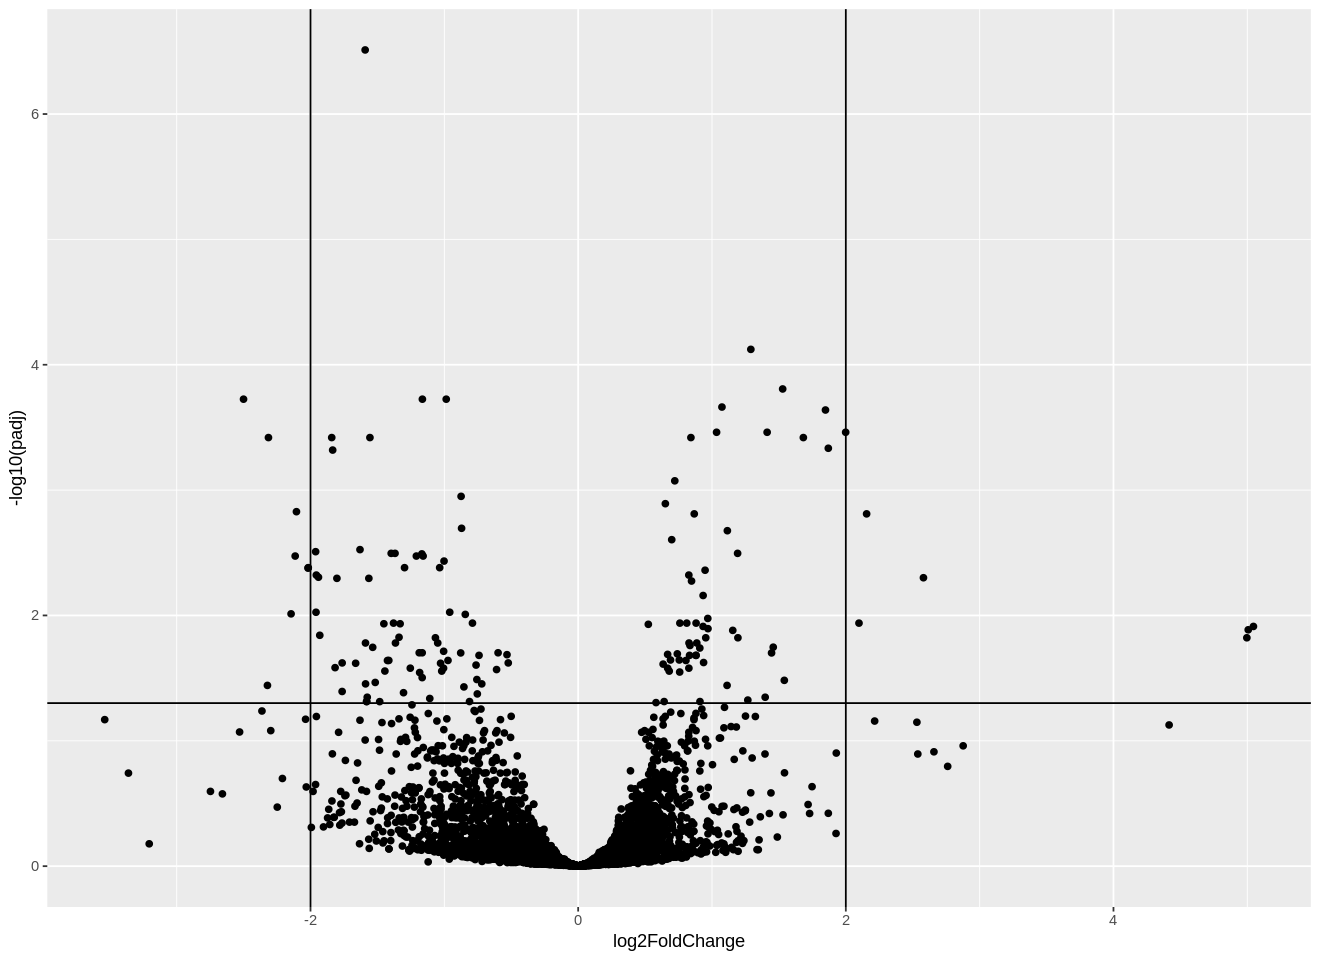

In [33]:
# Create and output volcano plot
volcano_data <- as_tibble(res, rownames = 'gene_id')
options(repr.plot.width = 11, repr.plot.height = 8)
volcano_plot <- volcano_data |> 
    ggplot(aes(x = log2FoldChange, y = -log10(padj))) +
    geom_point(na.rm = TRUE) +
    geom_vline(xintercept = 2) +
    geom_vline(xintercept = -2) +
    geom_hline(yintercept = -log10(0.05))
volcano_plot

The volcano plot shows that 14 genes in the miracidia from the two different tissue types that are signifficantly differentially expressed. The genes that were significant were genes that had a -log10(padj) > -log10(0.05) and had an absolue value of the log2 fold change greater than 2.

## Identification of differentially expressed genes

In [20]:
# Read in normalized counts and DESeq2 results
norm_counts <- read_csv('/data/classes/2025/spring/biol443/course_files/rnaseq_data/deseq_norm_counts.csv', show_col_types = FALSE)
degs <- read_csv('/data/classes/2025/spring/biol443/course_files/rnaseq_data/deseq_results.csv', show_col_types = FALSE)

# Filter data to only signifficant genes
degs_filtered <- degs |>
    filter(padj <= 0.05) |>
    filter(abs(log2FoldChange) > 2)

norm_counts_filtered <- norm_counts |>
    filter(gene_id %in% degs_filtered$gene_id)

norm_counts_filtered_long <- norm_counts_filtered |>
    pivot_longer(-gene_id, names_to = 'sample', values_to = 'norm_count') |>
    mutate(sample = str_remove(sample, "_S[0-9]{2}_L005")) |>
    separate(sample, c('sample', 'replicate'), "-")

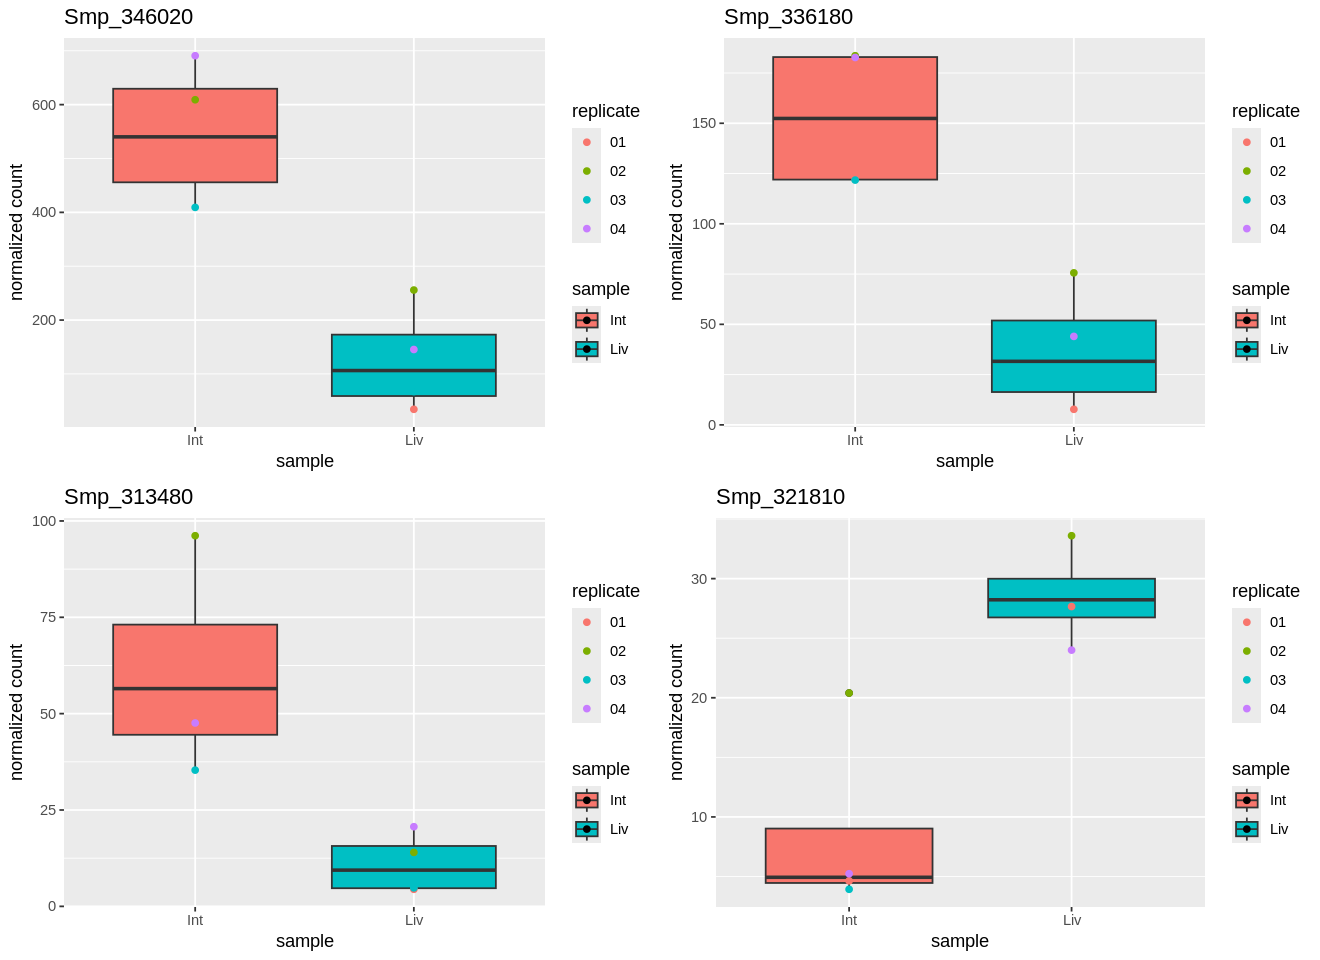

In [30]:
# Create and output four of the signifficantly differentially expressed genes

# Gene Smp_346020
plot1 <- norm_counts_filtered_long |>
    filter(gene_id == 'Smp_346020') |>
    ggplot(aes(x = sample, y = norm_count, fill = sample)) +
    geom_boxplot() +
    geom_point(aes(color = replicate)) +
    ggtitle("Smp_346020") +
    labs(y = "normalized count")

# Gene Smp_336180
plot2 <- norm_counts_filtered_long |>
    filter(gene_id == 'Smp_336180') |>
    ggplot(aes(x = sample, y = norm_count, fill = sample)) +
    geom_boxplot() +
    geom_point(aes(color = replicate)) +
    ggtitle("Smp_336180") +
    labs(y = "normalized count")

# Gene Smp_313480
plot3 <- norm_counts_filtered_long |>
    filter(gene_id == 'Smp_313480') |>
    ggplot(aes(x = sample, y = norm_count, fill = sample)) +
    geom_boxplot() +
    geom_point(aes(color = replicate)) +
    ggtitle("Smp_313480") +
    labs(y = "normalized count")

# Gene Smp_321810
plot4 <- norm_counts_filtered_long |>
    filter(gene_id == 'Smp_321810') |>
    ggplot(aes(x = sample, y = norm_count, fill = sample)) +
    geom_boxplot() +
    geom_point(aes(color = replicate)) +
    ggtitle("Smp_321810") +
    labs(y = "normalized count")

# Combine all four plots into one figure
options(repr.plot.width = 11, repr.plot.height = 8)
grid.arrange(plot1, plot2, plot3, plot4, nrow = 2)

The boxplots above show four of the 14 significantly differentially expressed genes where padj < 0.05 and the absolute value of the log2 fold change was greater than 2. The points on each boxplot represent the miricidia samples that the gene came from.

## Identification of pathways and/or GO annotations that are differentially expressed

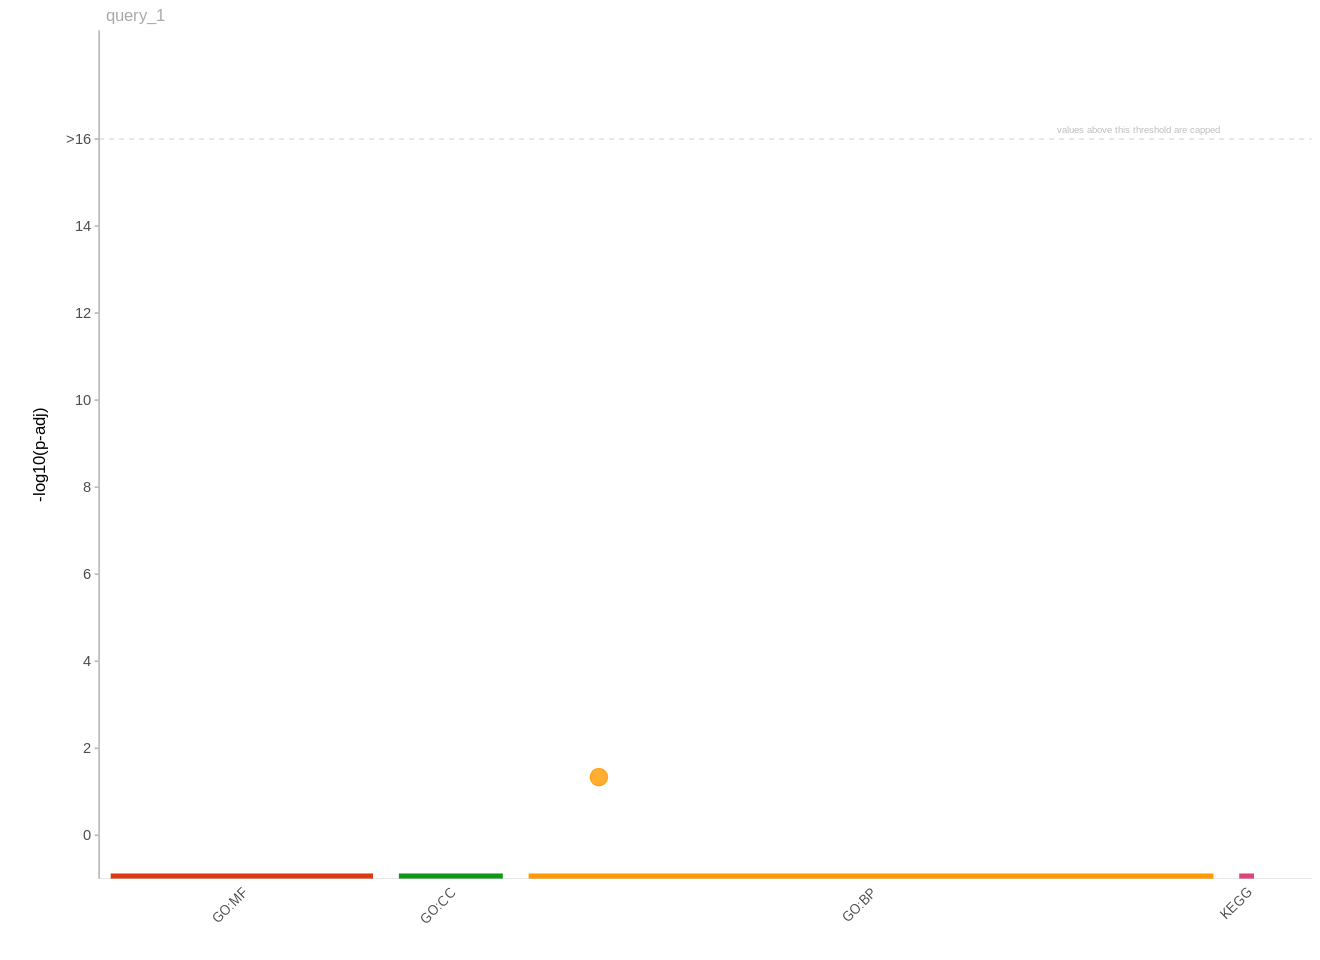

In [31]:
# Create and output GO analysis using gProfiler
options(repr.plot.width = 11, repr.plot.height = 8)
genes <- degs_filtered$gene_id
gostres <- gost(query = genes, organism = "smansoni")
gProfiler <- gostplot(gostres, interactive = FALSE)
gProfiler

The GO analysis revealed one statistically significant enrich term from the genes where padj < 0.05 and the absolute value of the log2 fold change was greater than 2. The function of this term is cell adhesion.

# Discussion

The results of our research conclude that miracidia from the liver and those from the intestines have signifficant differences in gene expression. This finding matches up with a previous study that determined there was also a difference in gene expression in the eggs from the liver versus those from the intestines.  
  
In the furture, we could look at if *S. mansoni* found in the liver versus the intestines continue to have differences in gene expression later in the life cycle or if they start to become more similar. It would be important to know if they are still different in the later stages of their life cycle when they are infecting humans. Another furture direction could be researching how these gene expression differences affect the miracida and attempt to discover why these specific genes are differentially expressed. Since experiments done previosly on *S. mansoni* mostly used the ones from the liver, it is important to see if the same results will be the same as those from the intestines that actually continue the life cycle.

# References

1.Kristýna Peterková, Lukáš Konečný, Tomáš Macháček, Jedličková L, Winkelmann F, Sombetzki M, et al. Winners vs. losers: Schistosoma mansoni intestinal and liver eggs exhibit striking differences in gene expression and immunogenicity. PLoS Pathogens. 2024 May 30;20(5):e1012268–8.  

‌2.Hudak D, Johnson D, Chalker A, Nicklas J, Franz E, Dockendorf T, et al. Open OnDemand: A web-based client portal for HPC centers. Journal of Open Source Software. 2018 May 14;3(25):622.  

‌3.de Sena Brandine G, Smith AD. Falco: high-speed FastQC emulation for quality control of sequencing data. F1000Research. 2019 Nov 7;8:1874.  

‌4.Martin M. Cutadapt removes adapter sequences from high-throughput sequencing reads. EMBnetjournal [Internet]. 2011 May 2;17(1):10. Available from: https://journal.embnet.org/index.php/embnetjournal/article/view/200. 

‌5.Dobin A, Davis CA, Schlesinger F, Drenkow J, Zaleski C, Jha S, et al. STAR: ultrafast universal RNA-seq aligner. Bioinformatics. 2012 Oct 25;29(1):15–21.  

‌6.Okonechnikov K, Conesa A, García-Alcalde F. Qualimap 2: advanced multi-sample quality control for high-throughput sequencing data. Bioinformatics. 2015 Oct 1;32(2):btv566.  

7‌‌.‌ ‌Picard toolkit. Broad Institute. 2019.  

8.Liao Y, Smyth GK, Shi W. featureCounts: an efficient general purpose program for assigning sequence reads to genomic features. Bioinformatics. 2013 Nov 13;30(7):923–30.  

‌9.Ewels P, Magnusson M, Lundin S, Käller M. MultiQC: summarize analysis results for multiple tools and samples in a single report. Bioinformatics. 2016 Jun 16;32(19):3047–8.  

‌10.Love MI, Huber W, Anders S. Moderated estimation of fold change and dispersion for RNA-seq data with DESeq2. Genome Biology. 2014 Dec;15(12):550.
